<a href="https://colab.research.google.com/github/RodrigoRoman/FullyConnectedNN/blob/main/FullyConnectedNN_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Deep Learning
## Fully Connected Deep Neural Networks

#### Implementation of a Fully Connected Network for Kaggle ASL Dataset

- Objective

This is the implementation of a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet).

The code is exclusively implemented using NumPy, aiming to provide a transparent and illustrative implementation of a deep fully connected neural network. This implementation serves as a valuable educational resource for understanding the inner workings of neural networks, showcasing concepts like forward and backward propagation, weight initialization, activation functions, and gradient descent optimization. It is designed to demystify the intricate details of neural network operations and empower learners with a solid foundation in deep learning.


In [99]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Get the path to the datasets

In [100]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load the data

In [101]:

asl_path = '/content/drive/My Drive/asl_data'
train_df = pd.read_csv(os.path.join(asl_path, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(asl_path, 'sign_mnist_valid.csv'))


In [102]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


# Import images

In [103]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [104]:
x_train.shape

(27455, 784)

In [105]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Create a function that will allow you to split the previously loaded validation set
    into validation and test.
    '''
    #We take the index of the images
    idxs = np.arange(x.shape[0])
    if(shuffle):
      #We need to shuffle those indexes
      np.random.shuffle(idxs)
    #We split our data based on the percentage indicated by pct
    #Considering pct to be the percentage of data destinated to validation
    split_point = int(y.shape[0]*pct)
    x_val = x[idxs[:split_point]]
    y_val = y[idxs[:split_point]]
    x_test = x[idxs[split_point:]]
    y_test = y[idxs[split_point:]]
    return x_val,y_val,x_test,y_test


In [106]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [107]:
### The following
alphabet=list(string.ascii_lowercase)
print(alphabet)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
24


### Normalise
We apply a straightforward normalization method, which involves dividing each pixel by the maximum possible value it can take.

In [108]:
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

### Graph images

Sign shown:  e


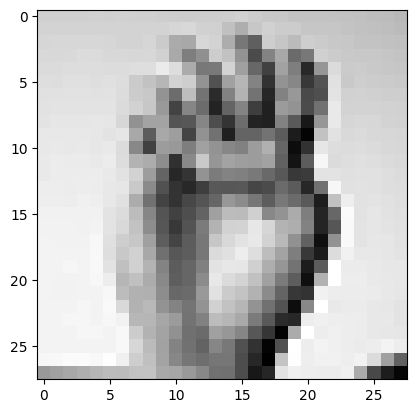

In [109]:
def showImage(image):
  #The images are already given as one dimensional array
  #So we need to reshape them
  plt.imshow(image.reshape(28,28),cmap=plt.get_cmap('gray'))

#We define a random index for graphing a random instance of the data
randIdx = np.random.randint(y_train.shape[0])
print("Sign shown: ",alphabet[y_train[randIdx]])
showImage(x_train[randIdx].reshape(28,28))

### Equations used for the model


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Initialization of parameters w and b

In [110]:
def init_parameters(inputSize,neuronsSizeList):
  parameters = {}
  for i,neuronSize in enumerate(neuronsSizeList):
    if(i == 0):
      # print('CREATING W0 -- neu Size- inputSize')
      # print(neuronSize,inputSize)
      parameters[f'w_{i}'] = np.random.randn(neuronSize,inputSize)*0.1
    else:
      parameters[f'w_{i}'] = np.random.randn(neuronSize,neuronsSizeList[i-1])*0.1

    parameters[f'b_{i}'] = np.zeros((neuronSize,1))
    # print('CREATING b0 -- neu Size- inputSize')
    # print(parameters[f'b_{i}'].shape)
  # print('Init Params')
  # print(parameters)
  return parameters

# Function for creating mini batches
This function is designed to facilitate the creation of mini-batches from a given dataset. The createMiniBatches function returns a generator object that yields mini-batches of data when iterated over. This can be used as the parameter to a loop

In [111]:
def createMiniBatches(x,y,shuffled=True,miniBatchSize=50):
  dataSize = y.shape[0]
  idxs = np.arange(dataSize)
  if(shuffled):
    np.random.shuffle(idxs)
  x = x[idxs]
  y = y[idxs]
  return ((x[i:i+miniBatchSize],y[i:i+miniBatchSize])for i in range(0,dataSize,miniBatchSize))

#We use ReLu as our activation function

In [112]:
def reLu(val):
  return np.maximum(0.01 * val, val)


#Layer Output Computation Function
This function computes both the linear equation outputs (denoted as 'z') and the neuron values after applying the specified activation function.

In [113]:
def computeScores(x,activationFunction,parameters):
  outputLayers = {}
  for i in range(len(parameters)//2):
    if(i==0):
      outputLayers[f'z_{i}'] =  parameters[f'w_{i}'] @ x.T + parameters[f'b_{i}']
    else:
      outputLayers[f'z_{i}'] = parameters[f'w_{i}'] @ outputLayers[f'a_{i-1}'] + parameters[f'b_{i}']
    outputLayers[f'a_{i}'] = activationFunction(outputLayers[f'z_{i}'])
  return outputLayers

# Softmax Activation Function

In the final layer, we apply the softmax activation function. This transformation converts the raw scores produced by our network into probability distributions, enabling us to interpret the network's outputs as class probabilities.

In [114]:
def softmax(lastLayerOutput):
  return np.exp(lastLayerOutput)/np.sum(np.exp(lastLayerOutput),axis=0)

#Cross Entropy
We use cross entropy to compute the Loss of our model

In [115]:
def x_entropy(probabilities, y,batchSize):
  y_prob = probabilities[y.squeeze(),np.arange(y.shape[0])]
  cost = np.sum(-np.log(y_prob))/batchSize
  return cost


#Gradient Computation Function
This function initiates the backpropagation process by first calculating layer scores and then proceeds to compute gradients for weight and bias parameters, along with gradients for activation functions (both 'a' and 'z'). Notably, these gradients are interconnected through the chain rule, reflecting their dependencies in the neural network's gradient flow.

In [116]:
def computeGradients(x,y,parameters,batchSize,computedScores):
  gradients = {}
  #Notice that we start counting layers from 0
  lastLayerIDX = len(parameters)//2 - 1
  scores = computedScores[f'z_{lastLayerIDX}']
  probs = softmax(scores)
  probs[y.squeeze(),np.arange(y.shape[0])] -= 1 # y-hat -y
  for i in range(lastLayerIDX,-1,-1):
    #Compute gradient of last layer
    if(i == lastLayerIDX):
      gradients[f'dz_{i}'] = probs.copy()
      gradients[f'dw_{i}'] = gradients[f'dz_{i}'] @ computedScores[f'a_{i-1}'].T/batchSize
      gradients[f'db_{i}'] = np.sum(gradients[f'dz_{i}'],axis=1, keepdims = True)/batchSize
    else:
      gradients[f'da_{i}'] = parameters[f'w_{i+1}'].T @ gradients[f'dz_{i+1}']
      activatedLayer = gradients[f'da_{i}'].copy()
      activatedLayer[computedScores[f'z_{i}']<=0] = 0
      gradients[f'dz_{i}'] = activatedLayer
      if(i !=0):
        gradients[f'dw_{i}'] = gradients[f'dz_{i}'] @ computedScores[f'a_{i-1}'].T
      else:
        gradients[f'dw_{i}'] = gradients[f'dz_{i}'] @ x
      gradients[f'db_{i}'] = np.sum(gradients[f'dz_{i}'],axis=1, keepdims = True)
  return gradients

#Update parameters
This function utilizes the gradients calculated during the initial phase of backpropagation to adjust the weight and bias values, applying a specified learning rate to modulate the magnitude of these updates for each parameter.

In [117]:
def updateParameters(parameters,learningRate,gradients):
  newParameters = parameters.copy()

  for i in range(len(parameters)//2):
    newParameters[f'w_{i}'] = parameters[f'w_{i}'] - learningRate * gradients[f'dw_{i}']
    newParameters[f'b_{i}'] = parameters[f'b_{i}'] - learningRate * gradients[f'db_{i}']
  return newParameters

#Auxiliar functions
Functions for evaluating the performance of the model

In [118]:
def predict(x, parameters, activationFunction):
    computedScores = computeScores(x, activationFunction, parameters)
    lastLayerIDX = len(parameters) // 2 - 1
    scores = computedScores[f'z_{lastLayerIDX}']
    probabilities = softmax(scores)
    predictions = np.argmax(probabilities, axis=0)
    return predictions

In [119]:
def evaluate(x_test, y_test, parameters, activationFunction):
    predictions = predict(x_test, parameters, activationFunction)
    accuracy = np.mean(predictions == y_test.squeeze()) * 100
    return accuracy


#Model Training
The training process encompasses several key steps, beginning with score computation for each layer, followed by parameter and activation gradient calculations, and concludes with parameter updates. Additionally, the model's accuracy is evaluated after each epoch using both training and validation datasets to gauge its performance.

In [120]:
def train(x_train,y_train,batchSize,neuronsSizeList,activationFunction,learningRate,epochs):
  #Initialize the parameters
  parameters = init_parameters(x_train.shape[1],neuronsSizeList)
  #Create the miniBatches
  miniBatches = list(createMiniBatches(x_train,y_train,batchSize))
  for epoch in range(epochs):
    correct = 0
    total = 0
    lastLayerIDX = len(parameters)//2 - 1
    for i , (x,y) in enumerate(miniBatches):
      outAZs = computeScores(x,activationFunction,parameters)
      gradients = computeGradients(x,y,parameters,batchSize,outAZs)
      #Update parameters
      parameters = updateParameters(parameters,learningRate,gradients)
      score = outAZs[f'z_{lastLayerIDX}']
      probabilities = softmax(score)
      correct += np.sum(np.argmax(probabilities,axis=0) == y.squeeze())
      total += probabilities.shape[1]
    accuracy = correct/total
    print(f'Current cost:{x_entropy(probabilities,y,batchSize)}, Accuracy: {(accuracy*100):.2f}%')
    print(f'Accuracy of validation: {evaluate(x_val, y_val, parameters, reLu):.2f}%')
  return parameters


In [121]:
modelParams = train(x_train,y_train,500,[200,200,200,200,200,len(alphabet)],reLu,0.001,10)

Current cost:0.02134512117995113, Accuracy: 28.45%
Accuracy of validation: 30.56%
Current cost:0.004569556030647787, Accuracy: 55.28%
Accuracy of validation: 46.49%
Current cost:0.005829045333283849, Accuracy: 71.91%
Accuracy of validation: 48.58%
Current cost:0.0024446759471941112, Accuracy: 84.49%
Accuracy of validation: 52.34%
Current cost:0.00022650136935624748, Accuracy: 88.43%
Accuracy of validation: 76.72%
Current cost:0.00019892305092944043, Accuracy: 93.76%
Accuracy of validation: 79.06%
Current cost:0.0001436796814184974, Accuracy: 95.00%
Accuracy of validation: 79.39%
Current cost:7.591647522060485e-05, Accuracy: 99.92%
Accuracy of validation: 81.12%
Current cost:4.760129821174421e-05, Accuracy: 100.00%
Accuracy of validation: 81.62%
Current cost:3.662444032797552e-05, Accuracy: 100.00%
Accuracy of validation: 81.73%


In [122]:
print(f'Accuracy: {evaluate(x_test, y_test, modelParams, reLu):.2f}%')


Accuracy: 81.93%


The predicted value is: c The real value is: c


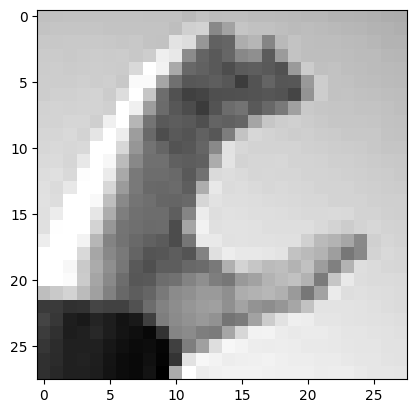

In [123]:
idx = np.random.randint(len(y_test))
showImage(x_test[idx])

# Ensure x_test[idx] is a 2D array with a single row
single_example = x_test[idx].reshape(1, -1)

# Get the prediction using the predict function
pred = predict(single_example, modelParams, reLu)

# Since predict returns predictions for all examples (even though there's just one),
# take the first (and only) prediction from the result.
pred_label = pred[0]

print(f'The predicted value is: {alphabet[pred_label]} The real value is: {alphabet[y_test[idx]]}')